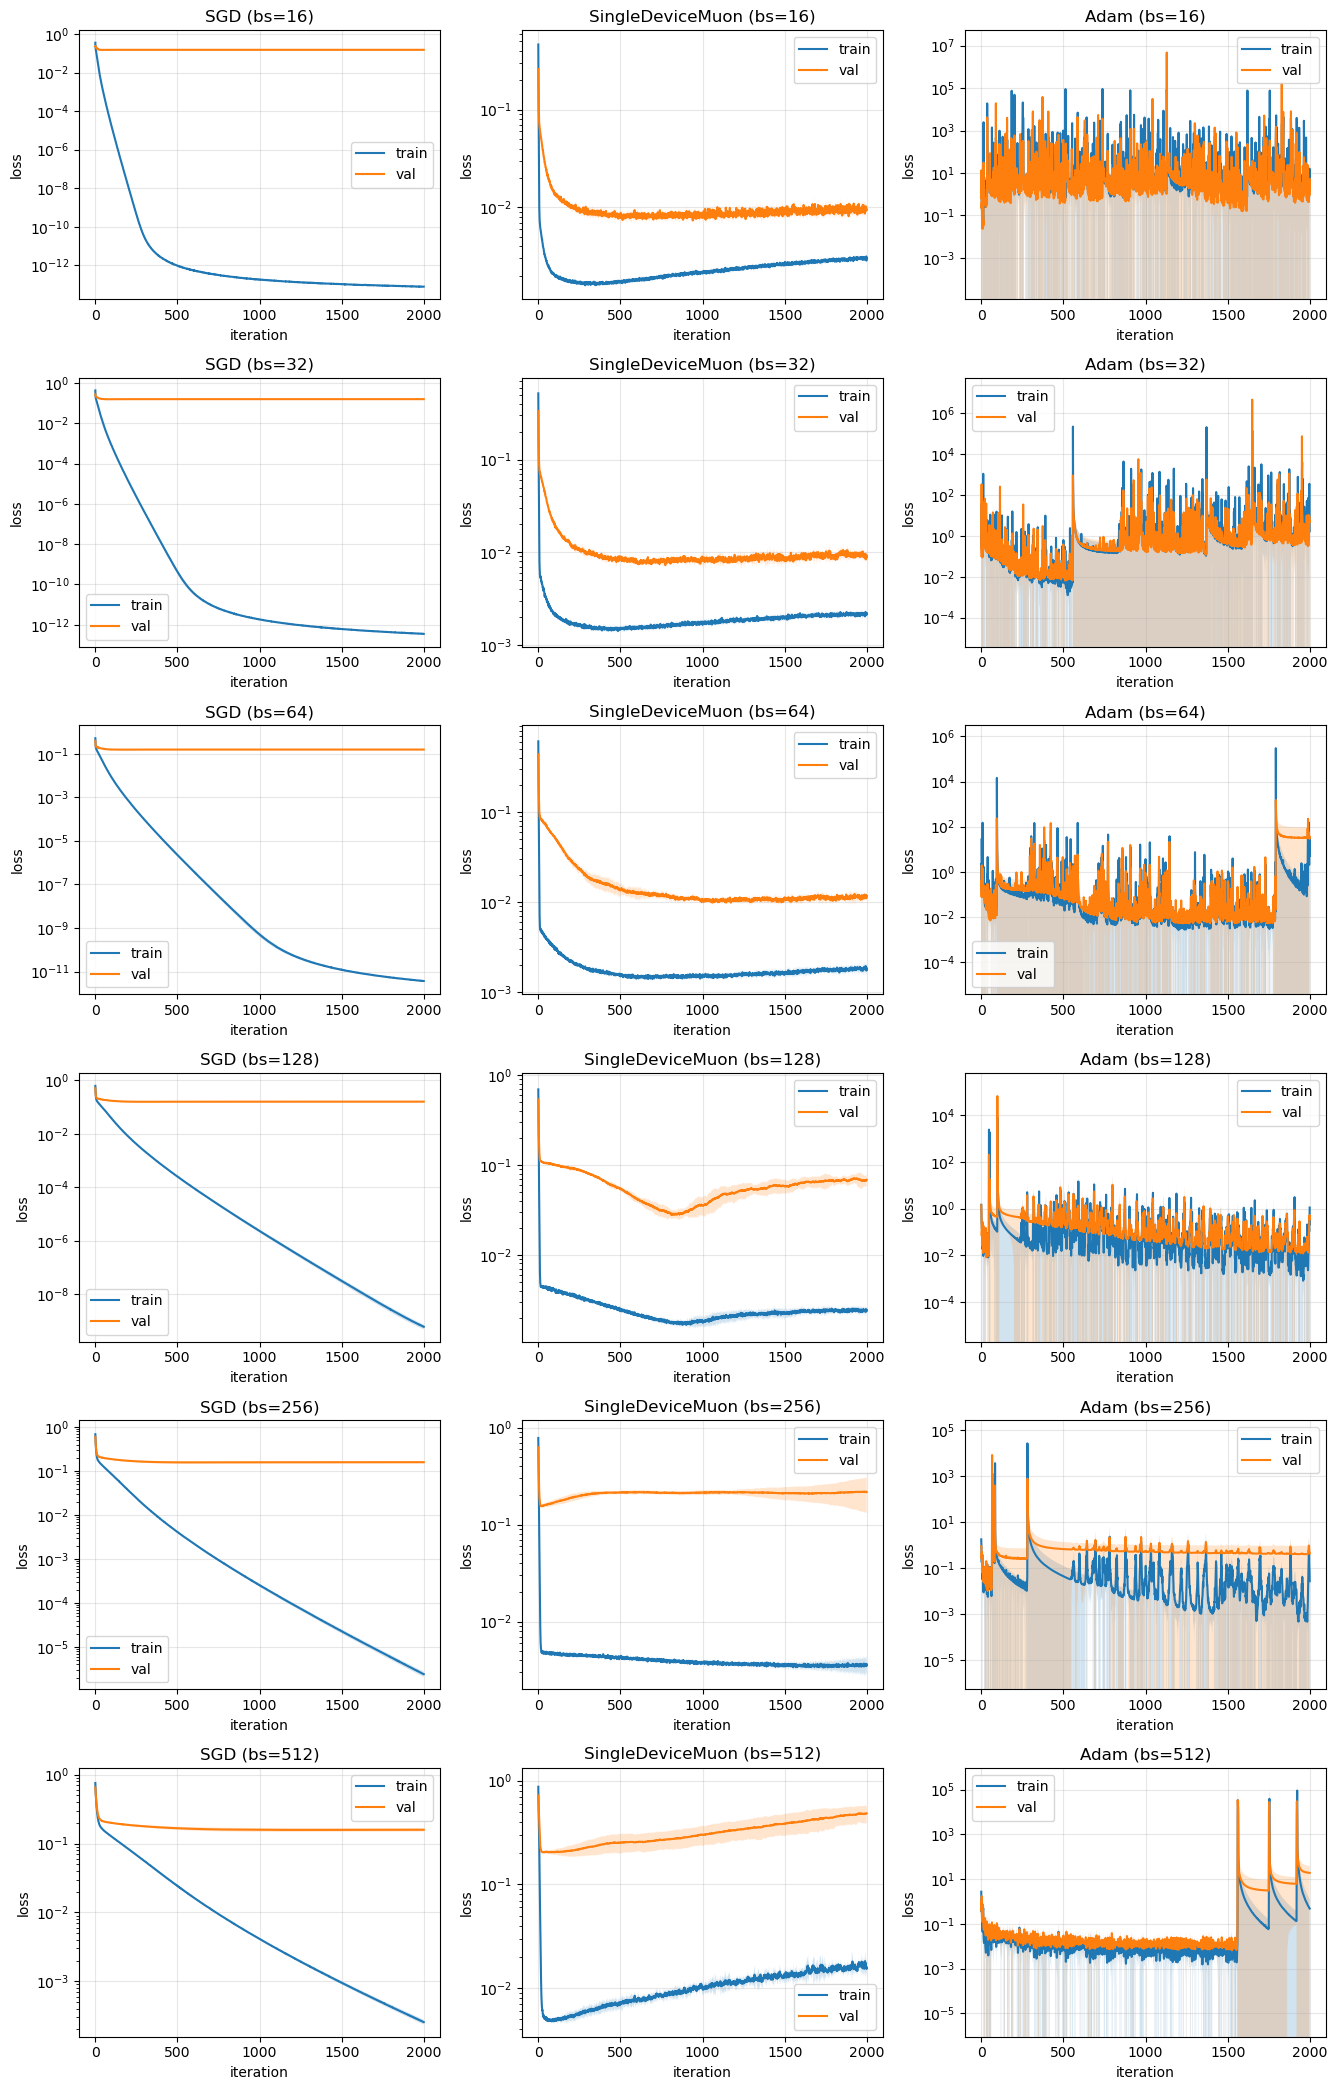

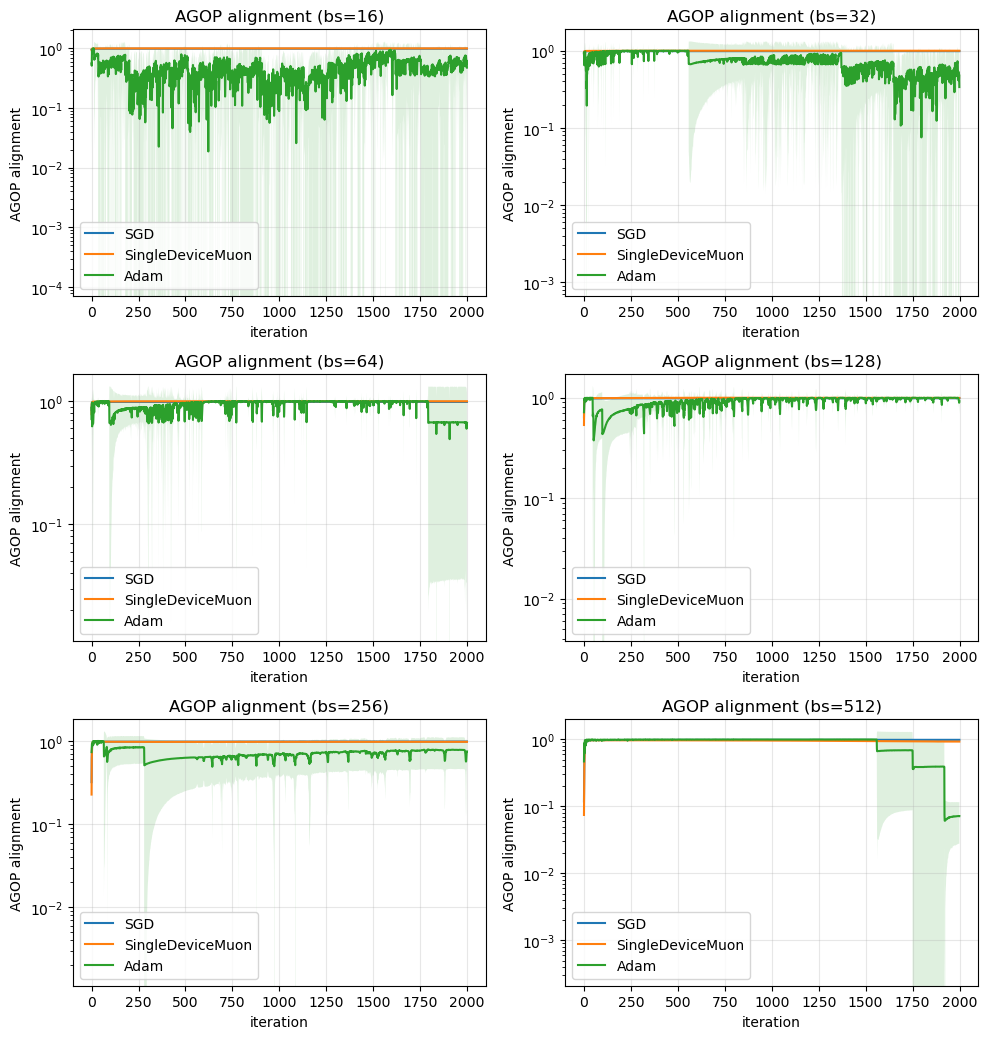

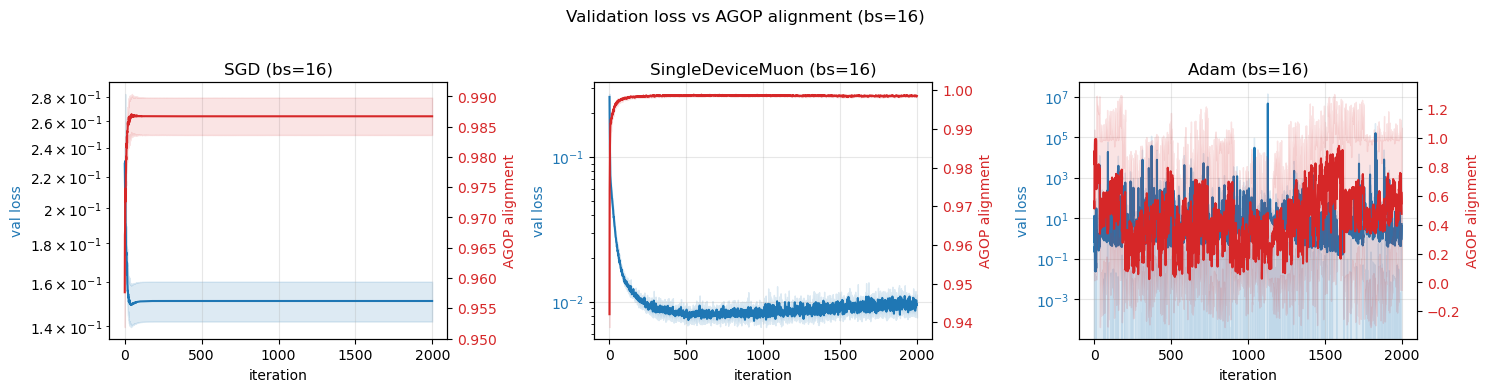

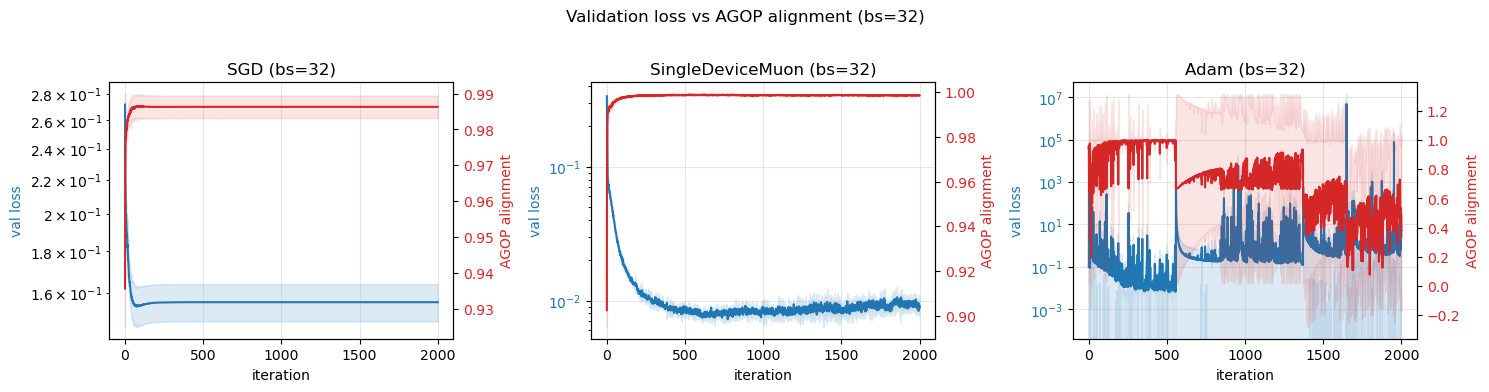

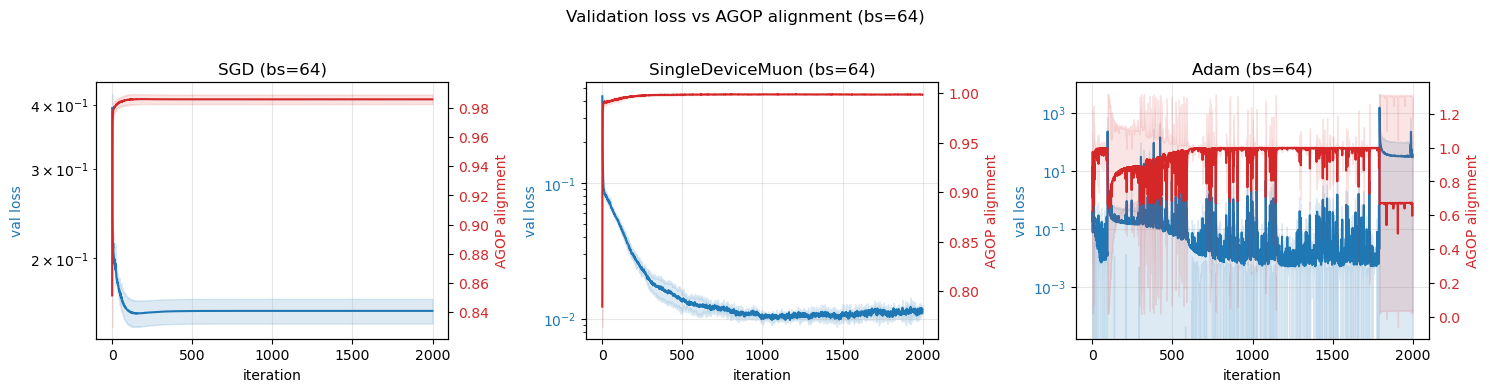

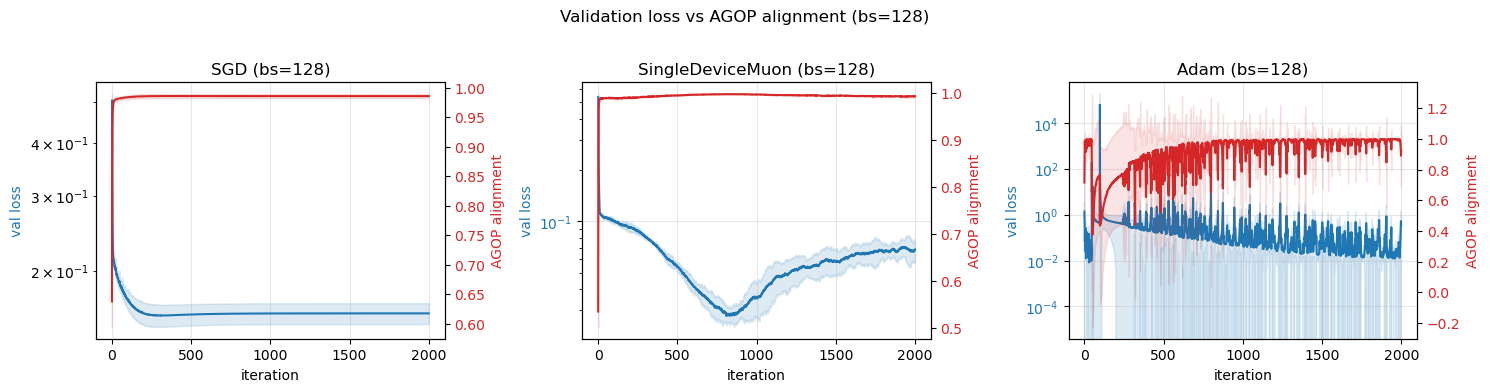

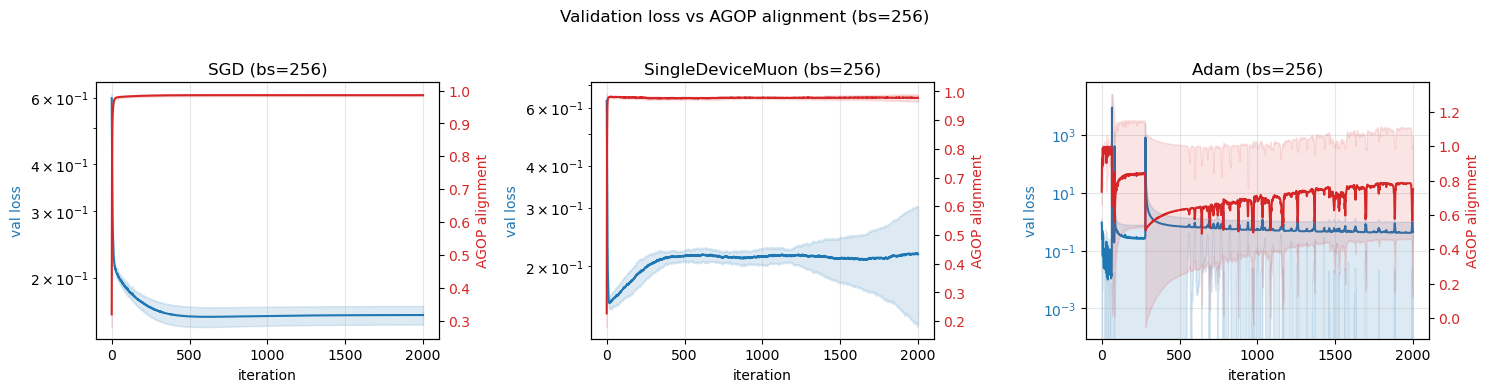

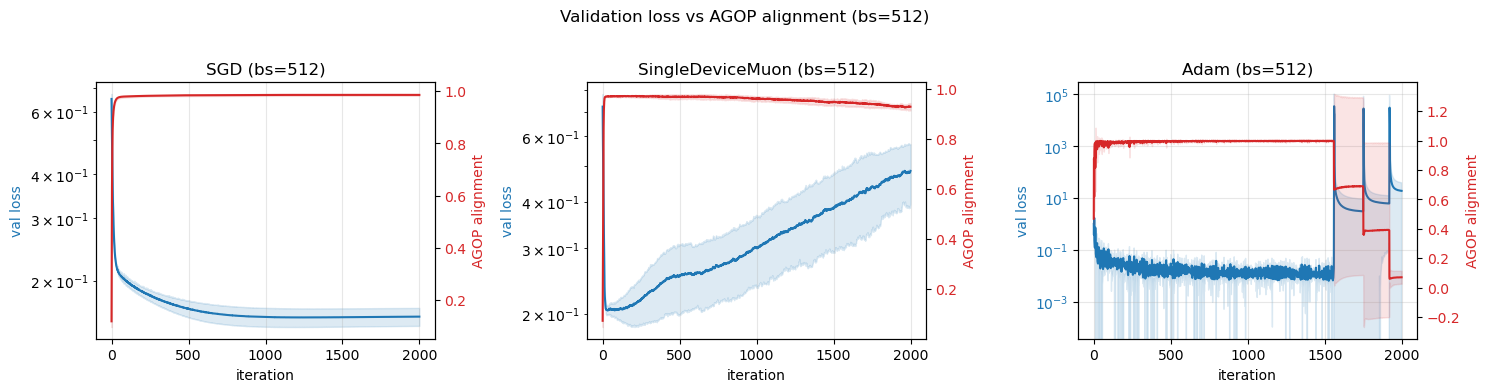

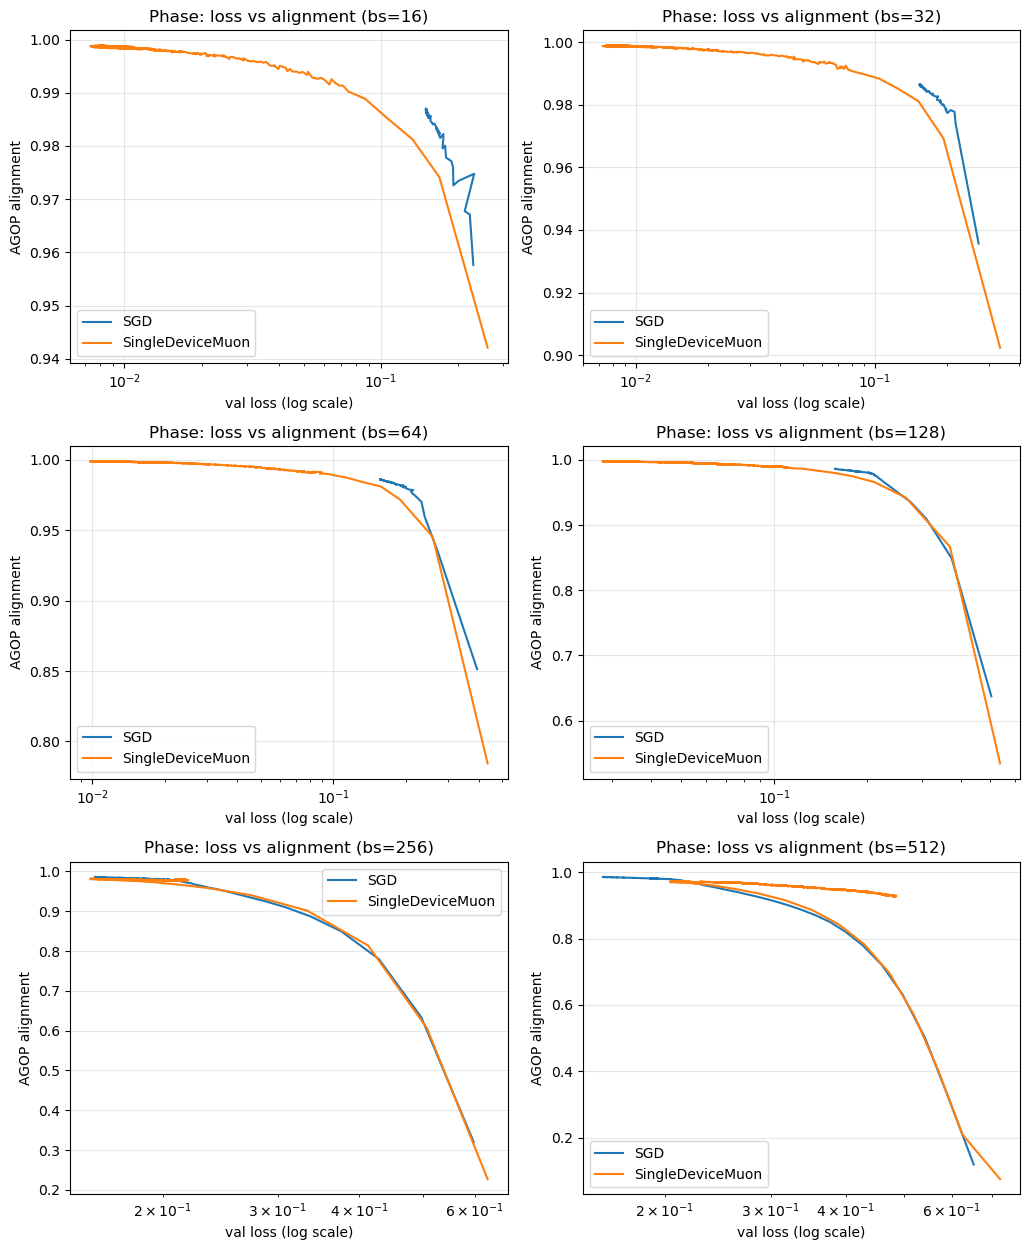

In [ ]:
import os
import re
import json
import glob
from collections import defaultdict
from typing import Dict, List, Tuple, Any

import numpy as np
import matplotlib.pyplot as plt


def _read_config_txt(path: str) -> Dict[str, Any]:
    """Read a config.txt that may be json-like or key: value pairs."""
    cfg: Dict[str, Any] = {}
    try:
        with open(path, "r") as f:
            text = f.read().strip()
        # Try JSON first
        try:
            maybe = json.loads(text)
            if isinstance(maybe, dict):
                return maybe
        except Exception:
            pass
        # Fallback: parse key[:=]value lines
        for line in text.splitlines():
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            if ":" in line:
                k, v = line.split(":", 1)
            elif "=" in line:
                k, v = line.split("=", 1)
            else:
                continue
            k = k.strip()
            v = v.strip()
            # try to coerce numbers/bools
            if re.fullmatch(r"-?\d+", v):
                cfg[k] = int(v)
            elif re.fullmatch(r"-?\d+\.\d*", v):
                cfg[k] = float(v)
            elif v.lower() in {"true", "false"}:
                cfg[k] = v.lower() == "true"
            else:
                cfg[k] = v
    except FileNotFoundError:
        pass
    return cfg


def _infer_optimizer_from_dir(dir_name: str) -> str:
    base = os.path.basename(dir_name.rstrip(os.sep))
    # e.g., "SGD_20251030_160156" -> "SGD"
    return base.split("_")[0]


def _classify_npy_file(fname: str) -> str:
    low = os.path.basename(fname).lower()
    # Heuristics
    if "agop" in low and ("align" in low or "alignment" in low):
        return "agop_alignment"
    if ("val" in low and "loss" in low) or ("loss_val" in low) or ("val_loss" in low):
        return "val_loss"
    if ("train" in low and "loss" in low) or ("loss_train" in low) or ("train_loss" in low):
        return "train_loss"
    # Unknown
    return "unknown"


def _load_runs_arrays(exp_dir: str) -> Dict[str, List[np.ndarray]]:
    """Load per-run arrays found in the experiment directory.

    Returns a dict with keys among {train_loss, val_loss, agop_alignment} mapping to list of arrays.
    """
    out: Dict[str, List[np.ndarray]] = defaultdict(list)
    for npy_path in sorted(glob.glob(os.path.join(exp_dir, "*.npy"))):
        kind = _classify_npy_file(npy_path)
        if kind == "unknown":
            continue
        try:
            arr = np.load(npy_path, allow_pickle=False)
            if isinstance(arr, np.ndarray):
                # Ensure 1D time series for plotting
                arr = np.asarray(arr).reshape(-1)
                out[kind].append(arr)
        except Exception:
            # Skip unreadable files
            continue
    return out


def _trim_and_stack(runs: List[np.ndarray]) -> np.ndarray:
    """Trim all runs to the minimum length and stack to shape (n_runs, T)."""
    if not runs:
        return np.empty((0, 0))
    T = min(len(r) for r in runs)
    if T == 0:
        return np.empty((len(runs), 0))
    return np.stack([r[:T] for r in runs], axis=0)


def _mean_and_ci(arr_2d: np.ndarray, ci: float = 0.95) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Compute mean and symmetric CI = mean ± z * std/sqrt(n).
    Returns (mean, lo, hi).
    """
    if arr_2d.size == 0:
        return np.array([]), np.array([]), np.array([])
    mean = arr_2d.mean(axis=0)
    n = arr_2d.shape[0]
    std = arr_2d.std(axis=0, ddof=1) if n > 1 else np.zeros_like(mean)
    # 95% normal approx
    z = 1.96 if abs(ci - 0.95) < 1e-9 else 1.96
    half = z * (std / max(n, 1)**0.5)
    return mean, mean - half, mean + half


def _safe_int_get(cfg: Dict[str, Any], keys: List[str], default: Any = None) -> Any:
    for k in keys:
        if k in cfg:
            return cfg[k]
        # try case-insensitive match
        for ck in cfg.keys():
            if ck.lower() == k.lower():
                return cfg[ck]
    return default


def collect_experiments(folder_name: str):
    """Scan folder_name for experiment subfolders and collect metadata and arrays.

    Returns:
      experiments: list of dicts with keys {optimizer, batch_size, dir, train_runs, val_runs, agop_runs}
    """
    experiments = []
    for entry in sorted(os.listdir(folder_name)):
        exp_dir = os.path.join(folder_name, entry)
        if not os.path.isdir(exp_dir):
            continue
        cfg = _read_config_txt(os.path.join(exp_dir, "config.txt"))
        optimizer = cfg.get("optimizer_name") or _infer_optimizer_from_dir(exp_dir)
        batch_size = _safe_int_get(cfg, ["batch_size", "Batch size", "batch", "bs"], None)
        arrays = _load_runs_arrays(exp_dir)
        experiments.append({
            "optimizer": optimizer,
            "batch_size": batch_size,
            "dir": exp_dir,
            "train_runs": arrays.get("train_loss", []),
            "val_runs": arrays.get("val_loss", []),
            "agop_runs": arrays.get("agop_alignment", []),
        })
    return experiments


def plot_train_val_grid(experiments: List[Dict[str, Any]], algorithms: List[str] = ("SGD", "SingleDeviceMuon", "Adam")):
    """Rows = batch sizes, Cols = algorithms; each subplot shows train and val with CI."""
    # Group experiments by (optimizer, batch_size)
    by_bs_algo: Dict[Any, Dict[str, Dict[str, np.ndarray]]] = defaultdict(dict)
    batch_sizes = []
    for exp in experiments:
        algo = exp["optimizer"]
        bs = exp["batch_size"]
        if algo not in algorithms:
            continue
        train = _trim_and_stack(exp["train_runs"]) if exp["train_runs"] else np.empty((0, 0))
        val = _trim_and_stack(exp["val_runs"]) if exp["val_runs"] else np.empty((0, 0))
        by_bs_algo[bs][algo] = {"train": train, "val": val}
        if bs not in batch_sizes:
            batch_sizes.append(bs)
    batch_sizes = sorted([b for b in batch_sizes if b is not None])

    nrows = len(batch_sizes)
    ncols = len(algorithms)
    if nrows == 0 or ncols == 0:
        print("No matching experiments to plot train/val grid.")
        return

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.5 * ncols, 3.5 * nrows), sharex=False)
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])
    elif ncols == 1:
        axes = axes.reshape(-1, 1)

    for i, bs in enumerate(batch_sizes):
        for j, algo in enumerate(algorithms):
            ax = axes[i, j]
            rec = by_bs_algo.get(bs, {}).get(algo)
            ax.set_title(f"{algo} (bs={bs})")
            if not rec:
                ax.text(0.5, 0.5, "No data", ha="center", va="center")
                ax.grid(True, alpha=0.3)
                continue
            # Train
            if rec["train"].size:
                mean, lo, hi = _mean_and_ci(rec["train"])
                t = np.arange(mean.shape[0])
                ax.plot(t, mean, label="train")
                ax.fill_between(t, lo, hi, alpha=0.2)
            # Val
            if rec["val"].size:
                mean, lo, hi = _mean_and_ci(rec["val"])
                t = np.arange(mean.shape[0])
                ax.plot(t, mean, label="val")
                ax.fill_between(t, lo, hi, alpha=0.2)
            ax.set_xlabel("iteration")
            ax.set_ylabel("loss")
            ax.set_yscale("log")
            ax.grid(True, alpha=0.3)
            ax.legend(loc="best")

    fig.tight_layout()
    plt.show()

from typing import List, Dict, Any
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

def plot_phase_loss_alignment_by_batch(experiments: List[Dict[str, Any]], algorithms: List[str] = ("SGD", "SingleDeviceMuon", "Adam")):
    """For each batch size, overlay mean trajectory in phase space: x=val loss(t), y=AGOP alignment(t)
    for both algorithms on the same axes. One subplot per batch size.
    """
    # Prepare grouped data
    by_bs_algo: Dict[Any, Dict[str, Dict[str, np.ndarray]]] = defaultdict(dict)
    batch_sizes = []
    for exp in experiments:
        algo = exp["optimizer"]
        bs = exp["batch_size"]
        if algo not in algorithms:
            continue
        val = _trim_and_stack(exp["val_runs"]) if exp["val_runs"] else np.empty((0, 0))
        ag = _trim_and_stack(exp["agop_runs"]) if exp["agop_runs"] else np.empty((0, 0))
        by_bs_algo[bs][algo] = {"val": val, "agop": ag}
        if bs not in batch_sizes:
            batch_sizes.append(bs)
    batch_sizes = sorted([b for b in batch_sizes if b is not None])

    if not batch_sizes:
        print("No data for phase plots (loss vs alignment).")
        return

    nrows = int(np.ceil(len(batch_sizes) / 2))
    ncols = 2 if len(batch_sizes) > 1 else 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5.2 * ncols, 4.2 * nrows), squeeze=False)

    for idx, bs in enumerate(batch_sizes):
        ax = axes[idx // ncols, idx % ncols]
        ax.set_title(f"Phase: loss vs alignment (bs={bs})")
        for algo in algorithms:
            # Comment out Adam for phase plot: x(t) = error(t), y(t) = agop_alignment(t)
            if algo == "Adam":
                continue
            rec = by_bs_algo.get(bs, {}).get(algo)
            if not rec:
                continue
            val_arr = rec["val"]
            ag_arr = rec["agop"]
            if val_arr.size == 0 or ag_arr.size == 0:
                continue
            # Match time length
            T = min(val_arr.shape[1], ag_arr.shape[1]) if val_arr.ndim == 2 and ag_arr.ndim == 2 else 0
            if T == 0:
                continue
            val_mean = val_arr[:, :T].mean(axis=0)
            ag_mean = ag_arr[:, :T].mean(axis=0)
            ax.plot(val_mean, ag_mean, label=algo)
        ax.set_xlabel("val loss (log scale)")
        ax.set_xscale("log")
        ax.set_ylabel("AGOP alignment")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")

    # Hide any unused axes
    total_slots = nrows * ncols
    for k in range(len(batch_sizes), total_slots):
        axes[k // ncols, k % ncols].axis('off')

    fig.tight_layout()
    plt.show()


def plot_agop_overlay_by_batch(experiments: List[Dict[str, Any]], algorithms: List[str] = ("SGD", "SingleDeviceMuon", "Adam")):
    """For each batch size, overlay AGOP alignment curves (with CI) for both algorithms on the same plot."""
    # Group by (bs, algo)
    by_bs_algo: Dict[Any, Dict[str, np.ndarray]] = defaultdict(dict)
    batch_sizes = []
    for exp in experiments:
        algo = exp["optimizer"]
        bs = exp["batch_size"]
        if algo not in algorithms:
            continue
        ag = _trim_and_stack(exp["agop_runs"]) if exp["agop_runs"] else np.empty((0, 0))
        by_bs_algo[bs][algo] = ag
        if bs not in batch_sizes:
            batch_sizes.append(bs)
    batch_sizes = sorted([b for b in batch_sizes if b is not None])

    if not batch_sizes:
        print("No AGOP alignment data found.")
        return

    nrows = int(np.ceil(len(batch_sizes) / 2))
    ncols = 2 if len(batch_sizes) > 1 else 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3.5 * nrows), squeeze=False)

    for idx, bs in enumerate(batch_sizes):
        ax = axes[idx // ncols, idx % ncols]
        ax.set_title(f"AGOP alignment (bs={bs})")
        for algo in algorithms:
            arr = by_bs_algo.get(bs, {}).get(algo)
            if arr is None or arr.size == 0:
                continue
            mean, lo, hi = _mean_and_ci(arr)
            t = np.arange(mean.shape[0])
            ax.plot(t, mean, label=algo)
            ax.fill_between(t, lo, hi, alpha=0.15)
        ax.set_xlabel("iteration")
        ax.set_ylabel("AGOP alignment")
        ax.set_yscale("log")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")

    # Hide any unused axes
    total_slots = nrows * ncols
    for k in range(len(batch_sizes), total_slots):
        axes[k // ncols, k % ncols].axis('off')

    fig.tight_layout()
    plt.show()


def plot_val_loss_vs_agop_per_batch(experiments: List[Dict[str, Any]], algorithms: List[str] = ("SGD", "SingleDeviceMuon", "Adam")):
    """For each batch size and each algorithm, plot val loss and AGOP on twin axes in the same subplot.
    One figure per batch size with both algorithms present as separate subplots.
    """
    # Organize data
    by_bs_algo: Dict[Any, Dict[str, Dict[str, np.ndarray]]] = defaultdict(dict)
    batch_sizes = []
    for exp in experiments:
        algo = exp["optimizer"]
        bs = exp["batch_size"]
        if algo not in algorithms:
            continue
        val = _trim_and_stack(exp["val_runs"]) if exp["val_runs"] else np.empty((0, 0))
        ag = _trim_and_stack(exp["agop_runs"]) if exp["agop_runs"] else np.empty((0, 0))
        by_bs_algo[bs][algo] = {"val": val, "agop": ag}
        if bs not in batch_sizes:
            batch_sizes.append(bs)
    batch_sizes = sorted([b for b in batch_sizes if b is not None])

    for bs in batch_sizes:
        fig, axes = plt.subplots(nrows=1, ncols=len(algorithms), figsize=(5 * len(algorithms), 3.8), squeeze=False)
        for j, algo in enumerate(algorithms):
            ax = axes[0, j]
            rec = by_bs_algo.get(bs, {}).get(algo)
            ax.set_title(f"{algo} (bs={bs})")
            if not rec or (rec["val"].size == 0 and rec["agop"].size == 0):
                ax.text(0.5, 0.5, "No data", ha="center", va="center")
                ax.grid(True, alpha=0.3)
                continue
            # Primary: val loss
            if rec["val"].size:
                mean, lo, hi = _mean_and_ci(rec["val"])
                t = np.arange(mean.shape[0])
                ax.plot(t, mean, color="tab:blue", label="val loss")
                ax.fill_between(t, lo, hi, color="tab:blue", alpha=0.15)
                ax.set_xlabel("iteration")
                ax.set_ylabel("val loss", color="tab:blue")
                ax.set_yscale("log")
                ax.tick_params(axis='y', labelcolor="tab:blue")
            # Secondary: agop alignment
            ax2 = ax.twinx()
            if rec["agop"].size:
                mean2, lo2, hi2 = _mean_and_ci(rec["agop"])
                t2 = np.arange(mean2.shape[0])
                ax2.plot(t2, mean2, color="tab:red", label="AGOP align")
                ax2.fill_between(t2, lo2, hi2, color="tab:red", alpha=0.12)
                ax2.set_ylabel("AGOP alignment", color="tab:red")
                ax2.tick_params(axis='y', labelcolor="tab:red")
            ax.grid(True, alpha=0.3)
        fig.suptitle(f"Validation loss vs AGOP alignment (bs={bs})", y=1.02)
        fig.tight_layout()
        plt.show()


def plot_all(folder_name: str,
             algorithms: List[str] = ("SGD", "SingleDeviceMuon", "Adam")):
    experiments = collect_experiments(folder_name)
    # Update algorithm names to a canonical set if variants are found
    # e.g., "SingleDeviceMuon" or "Muon"; map common variants
    mapped_algs = {
        "sgd": "SGD",
        "singledevicemuon": "SingleDeviceMuon",
        "muon": "SingleDeviceMuon",
        "adam": "Adam",
    }
    for e in experiments:
        key = str(e["optimizer"]).lower().replace(" ", "")
        e["optimizer"] = mapped_algs.get(key, e["optimizer"])

    plot_train_val_grid(experiments, algorithms=list(algorithms))
    plot_agop_overlay_by_batch(experiments, algorithms=list(algorithms))
    plot_val_loss_vs_agop_per_batch(experiments, algorithms=list(algorithms))
    plot_phase_loss_alignment_by_batch(experiments, algorithms=list(algorithms))


# Example usage (uncomment and set your folder):
folder_name = "compare_sgd_vs_muon_2layers"
plot_all(folder_name)
